In [3]:
from functions import * 
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# step1  feature extract.  include HOG / image bin / histom of color

In [4]:
# get the train samples

In [5]:

cars = glob.glob('vehicles/**/*.png')
notcars = glob.glob('non-vehicles/**/*.png')

print(len(cars))
print(len(notcars))

8792
8968


# use hog function and show

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



float32


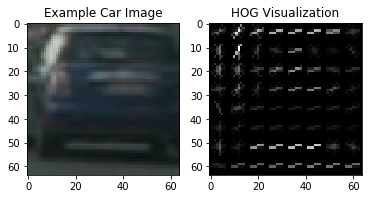

In [88]:
#Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])

#print(image)
print(image.dtype)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

mpimg.imsave('output/car.jpg',image)
mpimg.imsave('output/carhog.jpg',hog_image)

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



float32


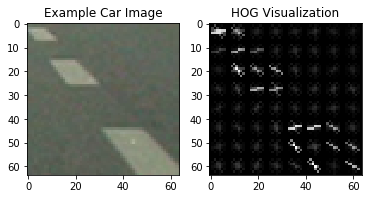

In [83]:
#Generate a random index to look at a car image
ind = np.random.randint(0, len(notcars))
# Read in the image
image = mpimg.imread(notcars[ind])

#print(image)
print(image.dtype)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.show()

mpimg.imsave('output/notcar.jpg',image)
mpimg.imsave('output/notcar-hog.jpg',hog_image)

### step2  using svm to classfy car 

In [75]:
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off


car_features = extract_features(cars, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell,
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space,
                                   spatial_size=spatial_size, hist_bins=hist_bins,
                                   orient=orient, pix_per_cell=pix_per_cell,
                                   cell_per_block=cell_per_block,
                                   hog_channel=hog_channel, spatial_feat=spatial_feat,
                                   hist_feat=hist_feat, hog_feat=hog_feat)
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print(len(y))

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



KeyboardInterrupt: 

In [8]:
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

12.32 Seconds to train SVC...
Test Accuracy of SVC =  0.9896
My SVC predicts:  [ 0.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  1.  0.  0.  1.  0.  1.]
0.00865 Seconds to predict 10 labels with SVC


In [9]:
import pickle
output = open('svc.pkl', 'wb')
output1 = open('scale.pkl','wb')
pickle.dump(svc, output)
pickle.dump(X_scaler,output1)

### step3 slide windows

In [10]:
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32,
                   hist_range=(0, 256), orient=9,
                   pix_per_cell=8, cell_per_block=2,
                   hog_channel=0, spatial_feat=True,
                   hist_feat=True, hog_feat=True):
    # 1) Create an empty list to receive positive detection windows
    on_windows = []
    # 2) Iterate over all windows in the list
    for window in windows:
        # 3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        # 4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        # 5) Scale extracted features to be fed to classifier

        xx = np.array(features).reshape(1, -1)
       # print(xx.shape)
        test_features = scaler.transform(xx)
        # 6) Predict using your classifier
        prediction = clf.predict(test_features)
        # 7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # 8) Return windows for positive detections
    return on_windows

In [65]:

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            features = single_img_features(subimg, color_space=color_space,
                                       spatial_size=spatial_size, hist_bins=hist_bins,
                                       orient=orient, pix_per_cell=pix_per_cell,
                                       cell_per_block=cell_per_block,
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)

            xx = np.array(features).reshape(1, -1)
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(xx)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



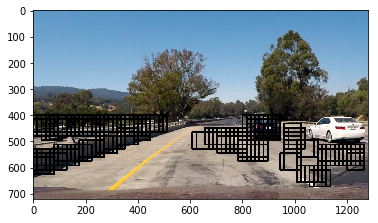

In [68]:
img = mpimg.imread('test_images/test1.jpg')
img = np.float32(img/255) 
window_img  =find_cars(img, 400, 700, 1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
plt.imshow(window_img)
plt.show()



  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



(720, 1280, 3)
float32


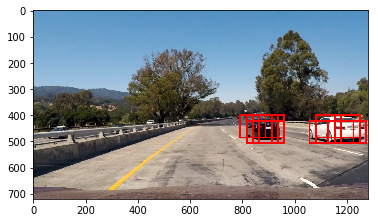

In [84]:

img = mpimg.imread('test_images/test1.jpg')
draw_image = np.copy(img)
img = np.float32(img/255)

print(img.shape)
print(img.dtype)
y_start_stop = [400,600]  # Min and max in y to search in slide_window()

windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                     xy_window=(96, 85), xy_overlap=(0.75, 0.75))

hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 

window_img = draw_boxes(draw_image, hot_windows, color=(255,0 , 0), thick=6)                    

plt.imshow(window_img)
plt.show()

mpimg.imsave('output/findwindow.jpg',window_img)

In [42]:

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        #print(heatmap.shape)
       #s print(1)
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 6)
    # Return the image
    return img

In [43]:
from scipy.ndimage.measurements import label

def label_imge(img,hot_windows,threadhold=1):

    heat_map = np.zeros_like(img)
    # Add heat to each box in box list
    heat = add_heat(heat_map,hot_windows)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threadhold)
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    #print(labels)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img,heatmap

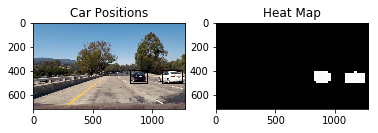

ValueError: Floating point image RGB values must be in the 0..1 range.

In [89]:
draw_img,heatmap = label_imge(img,hot_windows)
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.show()

#mpimg.imsave('output/carpositions.jpg',draw_img)

mpimg.imsave('output/heatmap.jpg',heatmap)


### step4 pipline

In [45]:
#############
output = open('svc.pkl', 'rb')
output1 = open('scale.pkl','rb')
svc = pickle.load(output)
X_scaler = pickle.load(output1)
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 16  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off
#############

def process(inp_img):    
    img = inp_img.copy()   
    img = np.float32(img/255)
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                     xy_window=(96, 85), xy_overlap=(0.75, 0.75))

    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat) 
    
    draw_img,heatmap = label_imge(inp_img,hot_windows)
   
    return draw_img  

/Users/allamtb/anaconda/envs/tensorflow/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


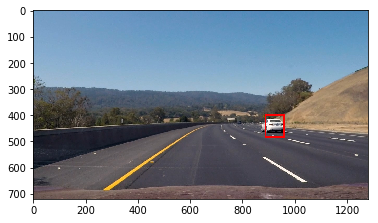

In [46]:
test_images = glob.glob('test_images/*.jpg')
image = mpimg.imread(test_images[2])
draw_img = process(image)
plt.imshow(draw_img)
plt.show()


In [70]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = 'project_video_proc.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process)  # NOTE: this function expects color images!!
white_clip.write_videofile(white_output, audio=False)

  'be changed to `L2-Hys` in v0.15', skimage_deprecation)



[MoviePy] >>>> Building video project_video_proc.mp4
[MoviePy] Writing video project_video_proc.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:01<27:00,  1.29s/it]


  0%|          | 2/1261 [00:02<27:12,  1.30s/it]


  0%|          | 3/1261 [00:03<27:03,  1.29s/it]


  0%|          | 4/1261 [00:05<27:11,  1.30s/it]


  0%|          | 5/1261 [00:06<27:02,  1.29s/it]


  0%|          | 6/1261 [00:07<27:17,  1.30s/it]


  1%|          | 7/1261 [00:09<28:19,  1.36s/it]


  1%|          | 8/1261 [00:10<28:47,  1.38s/it]


  1%|          | 9/1261 [00:12<28:40,  1.37s/it]


  1%|          | 10/1261 [00:13<29:25,  1.41s/it]


  1%|          | 11/1261 [00:15<30:47,  1.48s/it]


  1%|          | 12/1261 [00:17<33:07,  1.59s/it]


  1%|          | 13/1261 [00:18<32:54,  1.58s/it]


  1%|          | 14/1261 [00:20<33:43,  1.62s/it]


  1%|          | 15/1261 [00:22<34:31,  1.66s/it]


  1%|▏         | 16/1261 [00:23<35:44,  1.72s/it]


  1%|▏         | 17/1261 [00:25<35:16,  1.70s/it]


  1%|▏         | 18/1261 [00:27<35:23,  1.71s/it]


  2%|▏         | 19/1261 [0

 11%|█         | 134/1261 [03:20<25:30,  1.36s/it]


 11%|█         | 135/1261 [03:21<25:03,  1.33s/it]


 11%|█         | 136/1261 [03:22<24:45,  1.32s/it]


 11%|█         | 137/1261 [03:24<24:32,  1.31s/it]


 11%|█         | 138/1261 [03:25<24:33,  1.31s/it]


 11%|█         | 139/1261 [03:26<24:52,  1.33s/it]


 11%|█         | 140/1261 [03:28<24:58,  1.34s/it]


 11%|█         | 141/1261 [03:29<25:12,  1.35s/it]


 11%|█▏        | 142/1261 [03:31<25:49,  1.38s/it]


 11%|█▏        | 143/1261 [03:32<25:22,  1.36s/it]


 11%|█▏        | 144/1261 [03:33<24:49,  1.33s/it]


 11%|█▏        | 145/1261 [03:35<25:18,  1.36s/it]


 12%|█▏        | 146/1261 [03:36<25:30,  1.37s/it]


 12%|█▏        | 147/1261 [03:37<25:18,  1.36s/it]


 12%|█▏        | 148/1261 [03:39<25:08,  1.36s/it]


 12%|█▏        | 149/1261 [03:40<24:53,  1.34s/it]


 12%|█▏        | 150/1261 [03:41<24:31,  1.32s/it]


 12%|█▏        | 151/1261 [03:42<24:09,  1.31s/it]


 12%|█▏        | 152/1261 [03:44<24:22,  1.32s

 21%|██        | 266/1261 [06:25<24:40,  1.49s/it]


 21%|██        | 267/1261 [06:26<25:11,  1.52s/it]


 21%|██▏       | 268/1261 [06:28<26:17,  1.59s/it]


 21%|██▏       | 269/1261 [06:29<24:58,  1.51s/it]


 21%|██▏       | 270/1261 [06:31<23:56,  1.45s/it]


 21%|██▏       | 271/1261 [06:32<23:05,  1.40s/it]


 22%|██▏       | 272/1261 [06:33<22:29,  1.36s/it]


 22%|██▏       | 273/1261 [06:34<22:03,  1.34s/it]


 22%|██▏       | 274/1261 [06:36<21:48,  1.33s/it]


 22%|██▏       | 275/1261 [06:37<21:33,  1.31s/it]


 22%|██▏       | 276/1261 [06:38<21:30,  1.31s/it]


 22%|██▏       | 277/1261 [06:40<21:19,  1.30s/it]


 22%|██▏       | 278/1261 [06:41<21:11,  1.29s/it]


 22%|██▏       | 279/1261 [06:42<21:05,  1.29s/it]


 22%|██▏       | 280/1261 [06:43<21:09,  1.29s/it]


 22%|██▏       | 281/1261 [06:45<21:41,  1.33s/it]


 22%|██▏       | 282/1261 [06:46<22:55,  1.40s/it]


 22%|██▏       | 283/1261 [06:48<23:21,  1.43s/it]


 23%|██▎       | 284/1261 [06:49<23:20,  1.43s

 32%|███▏      | 398/1261 [09:28<19:19,  1.34s/it]


 32%|███▏      | 399/1261 [09:29<19:08,  1.33s/it]


 32%|███▏      | 400/1261 [09:31<19:15,  1.34s/it]


 32%|███▏      | 401/1261 [09:32<19:07,  1.33s/it]


 32%|███▏      | 402/1261 [09:33<19:06,  1.33s/it]


 32%|███▏      | 403/1261 [09:35<19:01,  1.33s/it]


 32%|███▏      | 404/1261 [09:36<19:09,  1.34s/it]


 32%|███▏      | 405/1261 [09:38<19:05,  1.34s/it]


 32%|███▏      | 406/1261 [09:39<19:10,  1.35s/it]


 32%|███▏      | 407/1261 [09:40<19:09,  1.35s/it]


 32%|███▏      | 408/1261 [09:42<19:07,  1.35s/it]


 32%|███▏      | 409/1261 [09:43<19:07,  1.35s/it]


 33%|███▎      | 410/1261 [09:44<19:08,  1.35s/it]


 33%|███▎      | 411/1261 [09:46<19:01,  1.34s/it]


 33%|███▎      | 412/1261 [09:47<19:04,  1.35s/it]


 33%|███▎      | 413/1261 [09:48<19:02,  1.35s/it]


 33%|███▎      | 414/1261 [09:50<19:14,  1.36s/it]


 33%|███▎      | 415/1261 [09:51<19:05,  1.35s/it]


 33%|███▎      | 416/1261 [09:52<18:56,  1.34s

 42%|████▏     | 530/1261 [12:32<18:17,  1.50s/it]


 42%|████▏     | 531/1261 [12:34<18:29,  1.52s/it]


 42%|████▏     | 532/1261 [12:35<17:49,  1.47s/it]


 42%|████▏     | 533/1261 [12:36<17:10,  1.42s/it]


 42%|████▏     | 534/1261 [12:37<16:46,  1.38s/it]


 42%|████▏     | 535/1261 [12:39<16:27,  1.36s/it]


 43%|████▎     | 536/1261 [12:40<16:13,  1.34s/it]


 43%|████▎     | 537/1261 [12:41<16:00,  1.33s/it]


 43%|████▎     | 538/1261 [12:43<15:54,  1.32s/it]


 43%|████▎     | 539/1261 [12:44<15:46,  1.31s/it]


 43%|████▎     | 540/1261 [12:45<15:43,  1.31s/it]


 43%|████▎     | 541/1261 [12:47<15:33,  1.30s/it]


 43%|████▎     | 542/1261 [12:48<15:39,  1.31s/it]


 43%|████▎     | 543/1261 [12:49<15:56,  1.33s/it]


 43%|████▎     | 544/1261 [12:51<15:48,  1.32s/it]


 43%|████▎     | 545/1261 [12:52<15:50,  1.33s/it]


 43%|████▎     | 546/1261 [12:53<15:59,  1.34s/it]


 43%|████▎     | 547/1261 [12:55<16:19,  1.37s/it]


 43%|████▎     | 548/1261 [12:56<16:25,  1.38s

 52%|█████▏    | 662/1261 [15:34<14:09,  1.42s/it]


 53%|█████▎    | 663/1261 [15:36<13:53,  1.39s/it]


 53%|█████▎    | 664/1261 [15:37<13:44,  1.38s/it]


 53%|█████▎    | 665/1261 [15:38<13:38,  1.37s/it]


 53%|█████▎    | 666/1261 [15:40<13:40,  1.38s/it]


 53%|█████▎    | 667/1261 [15:41<13:30,  1.37s/it]


 53%|█████▎    | 668/1261 [15:42<13:25,  1.36s/it]


 53%|█████▎    | 669/1261 [15:44<13:31,  1.37s/it]


 53%|█████▎    | 670/1261 [15:45<13:28,  1.37s/it]


 53%|█████▎    | 671/1261 [15:46<13:16,  1.35s/it]


 53%|█████▎    | 672/1261 [15:48<13:05,  1.33s/it]


 53%|█████▎    | 673/1261 [15:49<12:54,  1.32s/it]


 53%|█████▎    | 674/1261 [15:50<13:23,  1.37s/it]


 54%|█████▎    | 675/1261 [15:53<16:27,  1.69s/it]


 54%|█████▎    | 676/1261 [15:54<15:34,  1.60s/it]


 54%|█████▎    | 677/1261 [15:56<15:08,  1.56s/it]


 54%|█████▍    | 678/1261 [15:58<16:00,  1.65s/it]


 54%|█████▍    | 679/1261 [15:59<15:50,  1.63s/it]


 54%|█████▍    | 680/1261 [16:01<16:02,  1.66s

 63%|██████▎   | 794/1261 [18:44<11:03,  1.42s/it]


 63%|██████▎   | 795/1261 [18:45<11:00,  1.42s/it]


 63%|██████▎   | 796/1261 [18:46<10:51,  1.40s/it]


 63%|██████▎   | 797/1261 [18:48<10:42,  1.38s/it]


 63%|██████▎   | 798/1261 [18:49<10:50,  1.41s/it]


 63%|██████▎   | 799/1261 [18:51<10:50,  1.41s/it]


 63%|██████▎   | 800/1261 [18:52<10:51,  1.41s/it]


 64%|██████▎   | 801/1261 [18:54<11:42,  1.53s/it]


 64%|██████▎   | 802/1261 [18:55<11:46,  1.54s/it]


 64%|██████▎   | 803/1261 [18:57<11:31,  1.51s/it]


 64%|██████▍   | 804/1261 [18:58<11:35,  1.52s/it]


 64%|██████▍   | 805/1261 [19:00<11:30,  1.51s/it]


 64%|██████▍   | 806/1261 [19:01<11:08,  1.47s/it]


 64%|██████▍   | 807/1261 [19:03<10:50,  1.43s/it]


 64%|██████▍   | 808/1261 [19:04<10:39,  1.41s/it]


 64%|██████▍   | 809/1261 [19:05<10:29,  1.39s/it]


 64%|██████▍   | 810/1261 [19:07<10:24,  1.39s/it]


 64%|██████▍   | 811/1261 [19:08<10:25,  1.39s/it]


 64%|██████▍   | 812/1261 [19:10<10:38,  1.42s

 73%|███████▎  | 926/1261 [21:42<07:23,  1.32s/it]


 74%|███████▎  | 927/1261 [21:43<07:16,  1.31s/it]


 74%|███████▎  | 928/1261 [21:45<07:13,  1.30s/it]


 74%|███████▎  | 929/1261 [21:46<07:15,  1.31s/it]


 74%|███████▍  | 930/1261 [21:47<07:22,  1.34s/it]


 74%|███████▍  | 931/1261 [21:49<07:21,  1.34s/it]


 74%|███████▍  | 932/1261 [21:50<07:20,  1.34s/it]


 74%|███████▍  | 933/1261 [21:51<07:17,  1.33s/it]


 74%|███████▍  | 934/1261 [21:53<07:18,  1.34s/it]


 74%|███████▍  | 935/1261 [21:54<07:24,  1.36s/it]


 74%|███████▍  | 936/1261 [21:56<07:27,  1.38s/it]


 74%|███████▍  | 937/1261 [21:57<07:22,  1.37s/it]


 74%|███████▍  | 938/1261 [21:58<07:25,  1.38s/it]


 74%|███████▍  | 939/1261 [22:00<07:24,  1.38s/it]


 75%|███████▍  | 940/1261 [22:01<07:19,  1.37s/it]


 75%|███████▍  | 941/1261 [22:03<07:49,  1.47s/it]


 75%|███████▍  | 942/1261 [22:04<07:41,  1.45s/it]


 75%|███████▍  | 943/1261 [22:05<07:29,  1.41s/it]


 75%|███████▍  | 944/1261 [22:07<07:19,  1.39s

 84%|████████▍ | 1057/1261 [24:47<04:38,  1.36s/it]


 84%|████████▍ | 1058/1261 [24:48<04:37,  1.37s/it]


 84%|████████▍ | 1059/1261 [24:49<04:36,  1.37s/it]


 84%|████████▍ | 1060/1261 [24:51<04:55,  1.47s/it]


 84%|████████▍ | 1061/1261 [24:53<05:12,  1.56s/it]


 84%|████████▍ | 1062/1261 [24:54<05:05,  1.53s/it]


 84%|████████▍ | 1063/1261 [24:56<05:07,  1.55s/it]


 84%|████████▍ | 1064/1261 [24:58<05:07,  1.56s/it]


 84%|████████▍ | 1065/1261 [24:59<05:08,  1.57s/it]


 85%|████████▍ | 1066/1261 [25:01<04:56,  1.52s/it]


 85%|████████▍ | 1067/1261 [25:02<04:44,  1.47s/it]


 85%|████████▍ | 1068/1261 [25:03<04:33,  1.42s/it]


 85%|████████▍ | 1069/1261 [25:05<04:25,  1.38s/it]


 85%|████████▍ | 1070/1261 [25:06<04:19,  1.36s/it]


 85%|████████▍ | 1071/1261 [25:07<04:16,  1.35s/it]


 85%|████████▌ | 1072/1261 [25:08<04:13,  1.34s/it]


 85%|████████▌ | 1073/1261 [25:10<04:10,  1.33s/it]


 85%|████████▌ | 1074/1261 [25:11<04:08,  1.33s/it]


 85%|████████▌ | 1075/1261 [

 94%|█████████▍| 1187/1261 [27:48<01:37,  1.31s/it]


 94%|█████████▍| 1188/1261 [27:50<01:36,  1.32s/it]


 94%|█████████▍| 1189/1261 [27:51<01:35,  1.32s/it]


 94%|█████████▍| 1190/1261 [27:52<01:36,  1.36s/it]


 94%|█████████▍| 1191/1261 [27:54<01:45,  1.50s/it]


 95%|█████████▍| 1192/1261 [27:56<01:43,  1.50s/it]


 95%|█████████▍| 1193/1261 [27:57<01:41,  1.49s/it]


 95%|█████████▍| 1194/1261 [27:59<01:42,  1.52s/it]


 95%|█████████▍| 1195/1261 [28:00<01:42,  1.55s/it]


 95%|█████████▍| 1196/1261 [28:02<01:40,  1.54s/it]


 95%|█████████▍| 1197/1261 [28:04<01:40,  1.57s/it]


 95%|█████████▌| 1198/1261 [28:05<01:38,  1.56s/it]


 95%|█████████▌| 1199/1261 [28:06<01:32,  1.49s/it]


 95%|█████████▌| 1200/1261 [28:08<01:28,  1.44s/it]


 95%|█████████▌| 1201/1261 [28:09<01:24,  1.41s/it]


 95%|█████████▌| 1202/1261 [28:11<01:25,  1.46s/it]


 95%|█████████▌| 1203/1261 [28:12<01:28,  1.52s/it]


 95%|█████████▌| 1204/1261 [28:14<01:31,  1.60s/it]


 96%|█████████▌| 1205/1261 [

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_proc.mp4 



In [72]:
%%HTML
<video width="320" height="240" controls>
  <source src="project_video_proc.mp4" type="video/mp4">
</video>